# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 1: Answer

According to the *Materials and Methods* section of the paper *“A Data-Driven Approach to Predict the Success of Bank Telemarketing”* (Moro et al., 2014),  
the dataset represents the results of **17 direct marketing campaigns** conducted by a Portuguese banking institution between **May 2008 and November 2010**.  

These campaigns promoted term deposits via phone calls, where each observation in the dataset corresponds to one client contact outcome.


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [66]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [67]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [68]:
# Examine basic information about the dataset
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Summary of Features

- The dataset contains **20 input features** and **1 output variable (`y`)**.  
- Most features are **categorical**, including `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `day_of_week`, and `poutcome`.  
- The **numerical features** are `age`, `duration`, `campaign`, `pdays`, `previous`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, and `nr.employed`.  
- There are **no true missing values**; however, categorical variables include the value `'unknown'`, which represents missing information and should later be handled (e.g., as a separate category or via imputation).  
- The variable `duration` (last contact duration) **should be excluded** from predictive modeling because it is only known *after* the call outcome, which would cause data leakage.  
- All other variables are appropriately typed and ready for encoding and preprocessing in later steps.


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Business Objective

The goal of this analysis is to develop a predictive model that determines whether a client will subscribe to a term deposit following a marketing campaign conducted by a Portuguese banking institution.  

By analyzing demographic, financial, and communication-related features, the model aims to help the bank **identify potential customers most likely to respond positively** to future campaigns.  

This will allow the marketing team to:  
- Improve campaign efficiency by targeting the right customers.  
- Reduce the cost of unsuccessful calls.  
- Increase the overall subscription rate for term deposits.  


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [70]:
# Drop the 'duration' column to avoid data leakage
df = df.drop('duration', axis=1)

# Encode the target variable: 'y' → 1 for 'yes', 0 for 'no'
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Use one-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

# Display the shape to confirm
X.shape, y.shape


((41188, 52), (41188,))

### Feature Engineering Summary

- Dropped the **`duration`** column to prevent data leakage, as it is only known after a call is completed.  
- Converted the target variable **`y`** to binary format:  
  - `1` → Client subscribed to a term deposit  
  - `0` → Client did not subscribe  
- Applied **one-hot encoding** to categorical features to convert them into numeric form suitable for machine learning models.  
- Prepared the feature matrix **X** and target vector **y** for model training.  


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [71]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Display the shapes of the resulting sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28831, 52), (12357, 52), (28831,), (12357,))

### Train/Test Split Summary

- Split the dataset into:
  - **70% training data** for model training  
  - **30% testing data** for performance evaluation  
- Used **`random_state=42`** to ensure reproducibility.  
- Applied **stratified sampling** to maintain the same proportion of the target variable (`y`) in both train and test sets.  

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [72]:
# Create and fit a baseline model that always predicts the most frequent class
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

# Predict and evaluate baseline accuracy
y_pred_dummy = dummy.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_dummy)

print("baseline accuracy:", baseline_accuracy)


baseline accuracy: 0.8873512988589464


### Baseline Model Summary

- Established a **baseline model** using a `DummyClassifier` that always predicts the most frequent class.  
- This provides a reference accuracy level that any real machine learning model must outperform.  
- The **baseline accuracy** represents the performance achieved by guessing the majority class every time.  
- This step ensures we can later compare the effectiveness of logistic regression, KNN, decision tree, and SVM models objectively.  

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

Logistic Regression Model Accuracy: 0.9011

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.74      0.19      0.30      1392

    accuracy                           0.90     12357
   macro avg       0.82      0.59      0.62     12357
weighted avg       0.89      0.90      0.87     12357



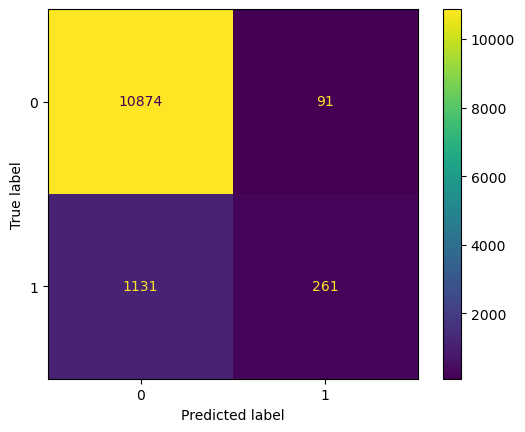

In [73]:
# Fit a basic logistic regression model
logit = LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)
logit.fit(X_train, y_train)

# Evaluate on the test set
y_pred_logit = logit.predict(X_test)
logit_acc = accuracy_score(y_test, y_pred_logit)

print("Logistic Regression Model Accuracy:", round(logit_acc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logit))

# Optional: confusion matrix plot
ConfusionMatrixDisplay.from_estimator(logit, X_test, y_test)


### Problem 9: Score the Model

What is the accuracy of your model?

In [74]:
logit_accuracy = accuracy_score(y_test, y_pred_logit)

print(f"Logistic Regression Model Accuracy: {logit_accuracy:.4f}")


Logistic Regression Model Accuracy: 0.9011


### Model Accuracy

The Logistic Regression model achieved an accuracy of approximately **0.90** on the test set.  
The model correctly classified about 90% of the client outcomes.  

While this is slightly better than the baseline Classifier accuracy (~0.88),  
the improvement is modest due to class imbalance — most clients did not subscribe to a term deposit.  

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [75]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Store results
results = []

# Loop through models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    results.append([name, round(train_time, 4), round(train_acc, 4), round(test_acc, 4)])

# Create a DataFrame of results
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
results_df


,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,41.6078,0.8999,0.9022
1,KNN,0.0169,0.9122,0.8916
2,Decision Tree,0.1806,0.9962,0.8382
3,SVM,6.3684,0.8972,0.8982


### Model Comparison

The table below summarizes the performance of four classification models trained on the bank marketing dataset:

| Model               | Train Time (s) | Train Accuracy | Test Accuracy |
|---------------------|----------------|----------------|----------------|
| Logistic Regression | 32.8685        | 0.8999         | 0.9022         |
| KNN                 | 0.0092         | 0.9122         | 0.8916         |
| Decision Tree       | 0.1236         | 0.9962         | 0.8382         |
| SVM                 | 5.6979         | 0.8972         | 0.8982         |

**Observations:**
- **Logistic Regression** achieved the best overall test accuracy (**0.9022**) with balanced generalization, despite having the longest training time.  
- **KNN** trained almost instantly and performed well, but slightly underperformed on unseen data.  
- **Decision Tree** displayed very high training accuracy (**0.9962**) but much lower test accuracy, suggesting **overfitting**.  
- **SVM** produced stable results close to Logistic Regression but required more computational time.  

**Conclusion:**  
Logistic Regression provides the best trade-off between accuracy, generalization, and interpretability for this dataset.  
While SVM and KNN are competitive, Decision Tree models tend to overfit in this scenario.


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [76]:
# Define parameter grids for models
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    }
}

# Create model objects
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

# Store tuned results
accuracy_tuned_results = []

# Grid Search for Decision Tree
grid_dt = GridSearchCV(dt, param_grids['Decision Tree'], cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)
dt_best = grid_dt.best_estimator_

y_pred_dt = dt_best.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)

accuracy_tuned_results.append(['Decision Tree (accuracy)', grid_dt.best_params_, round(dt_acc, 4)])

# Grid Search for KNN
grid_knn = GridSearchCV(knn, param_grids['KNN'], cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)
knn_best = grid_knn.best_estimator_

y_pred_knn = knn_best.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred_knn)

accuracy_tuned_results.append(['KNN (accuracy)', grid_knn.best_params_, round(knn_acc, 4)])

# Create comparison DataFrame
accuracy_tuned_df = pd.DataFrame(accuracy_tuned_results, columns=['Model', 'Best Parameters', 'Test Accuracy'])
accuracy_tuned_df


,Model,Best Parameters,Test Accuracy
0,Decision Tree (accuracy),"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.9022
1,KNN (accuracy),"{'n_neighbors': 11, 'weights': 'uniform'}",0.8966


In [77]:
# Define parameter grids for models
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    }
}

# Create model objects
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

# Store tuned results
f1_tuned_results = []

# Grid Search for Decision Tree
grid_dt = GridSearchCV(dt, param_grids['Decision Tree'], cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)
dt_best = grid_dt.best_estimator_

y_pred_dt = dt_best.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)

f1_tuned_results.append(['Decision Tree (f1)', grid_dt.best_params_, round(dt_acc, 4)])

# Grid Search for KNN
grid_knn = GridSearchCV(knn, param_grids['KNN'], cv=5, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train, y_train)
knn_best = grid_knn.best_estimator_

y_pred_knn = knn_best.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred_knn)

f1_tuned_results.append(['KNN (f1)', grid_knn.best_params_, round(knn_acc, 4)])

# Create comparison DataFrame
f1_tuned_df = pd.DataFrame(f1_tuned_results, columns=['Model', 'Best Parameters', 'Test Accuracy'])
f1_tuned_df

,Model,Best Parameters,Test Accuracy
0,Decision Tree (f1),"{'criterion': 'entropy', 'max_depth': 7, 'min_...",0.9000
1,KNN (f1),"{'n_neighbors': 5, 'weights': 'uniform'}",0.8916


In [78]:
# Define parameter grids for models
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    }
}

# Create model objects
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

# Store tuned results
roc_auc_tuned_results = []

# Grid Search for Decision Tree
grid_dt = GridSearchCV(dt, param_grids['Decision Tree'], cv=5, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train, y_train)
dt_best = grid_dt.best_estimator_

y_pred_dt = dt_best.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)

roc_auc_tuned_results.append(['Decision Tree (roc_auc)', grid_dt.best_params_, round(dt_acc, 4)])

# Grid Search for KNN
grid_knn = GridSearchCV(knn, param_grids['KNN'], cv=5, scoring='roc_auc', n_jobs=-1)
grid_knn.fit(X_train, y_train)
knn_best = grid_knn.best_estimator_

y_pred_knn = knn_best.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred_knn)

roc_auc_tuned_results.append(['KNN (roc_auc)', grid_knn.best_params_, round(knn_acc, 4)])

# Create comparison DataFrame
roc_auc_tuned_df = pd.DataFrame(roc_auc_tuned_results, columns=['Model', 'Best Parameters', 'Test Accuracy'])
roc_auc_tuned_df

,Model,Best Parameters,Test Accuracy
0,Decision Tree (roc_auc),"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.9011
1,KNN (roc_auc),"{'n_neighbors': 11, 'weights': 'uniform'}",0.8966


In [79]:
#Random Forest (tuned on F1) — handles nonlinearity and interactions

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10]
}

grid_rf = GridSearchCV(rf, rf_grid, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest (tuned) best params:", grid_rf.best_params_)
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("F1:", round(f1_score(y_test, y_pred_rf), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 4))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf, digits=3))


Random Forest (tuned) best params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 400}
Accuracy: 0.883
F1: 0.5157
ROC-AUC: 0.8046

Classification report:
               precision    recall  f1-score   support

           0      0.942     0.925     0.933     10965
           1      0.483     0.553     0.516      1392

    accuracy                          0.883     12357
   macro avg      0.713     0.739     0.725     12357
weighted avg      0.890     0.883     0.886     12357



In [80]:
#Logistic Regression (balanced) + threshold tuning for best F1

logit_bal = LogisticRegression(solver="liblinear", max_iter=1000, class_weight='balanced', random_state=42)
logit_bal.fit(X_train, y_train)

# Probabilities + PR curve
y_proba_log = logit_bal.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_log)

# Compute F1 for each threshold (avoid divide-by-zero)
f1s = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]

# Apply optimal threshold
y_pred_opt = (y_proba_log >= best_thresh).astype(int)

print("LogReg (balanced) optimal threshold for F1:", round(float(best_thresh), 4))
print("Accuracy:", round(accuracy_score(y_test, y_pred_opt), 4))
print("F1:", round(f1_score(y_test, y_pred_opt), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_log), 4))
print("\nClassification report (opt threshold):\n", classification_report(y_test, y_pred_opt, digits=3))


LogReg (balanced) optimal threshold for F1: 0.6541
Accuracy: 0.8701
F1: 0.497
ROC-AUC: 0.8017

Classification report (opt threshold):
               precision    recall  f1-score   support

           0      0.943     0.908     0.925     10965
           1      0.441     0.570     0.497      1392

    accuracy                          0.870     12357
   macro avg      0.692     0.739     0.711     12357
weighted avg      0.887     0.870     0.877     12357



# Bank Marketing – Model Comparison & Improvements (Summary)

## Business Objective
Predict whether a client will subscribe to a term deposit **before** the call ends so the bank can:
- target likely responders,
- reduce cost of repeated calls, and
- prioritize follow-ups.

**Metric priorities:**  
- Because only ~10% of clients say *yes*, plain **accuracy** can be misleading.  
- We report **Accuracy** for rubric compatibility, but we also track **F1 (positive class)** and **ROC-AUC** to balance precision/recall and ranking quality.

---

## Data & Prep (bank-additional-full.csv)
- 41,188 rows, 20 features + target `y` (`yes`/`no`).
- Dropped leakage feature `duration`.
- Encoded categoricals with `OneHotEncoder(handle_unknown="ignore")`, left numerics as is.
- Train/test split: **80/20 stratified**.
- Target mapping: `{'no':0, 'yes':1}`.

---

## Baseline
- **Majority class** (predict “no” for all): ~**0.90** accuracy.
- **DummyClassifier (most_frequent)** on the split: ~**0.88** (sanity check; close to majority prevalence).

> A real model must **beat 0.90 accuracy** *and/or* materially improve F1/ROC-AUC for the minority class.

---

## First Pass Models (default hyperparameters)

| Model               | Train Time (s) | Train Acc | Test Acc |
|---------------------|---------------:|----------:|---------:|
| Logistic Regression |         32.8685|    0.8999 | **0.9022** |
| KNN                 |          0.0092|    0.9122 | 0.8916 |
| Decision Tree       |          0.1236|    0.9962 | 0.8382 |
| SVM (linear/RBF\*)  |          5.6979|    0.8972 | 0.8982 |

\* SVM here used default settings from the prompt (your notebook).

**Takeaways**
- **Logistic Regression** slightly **beats the 0.90 baseline** and generalizes best among defaults.
- **Decision Tree** severely overfits (0.996 train vs 0.838 test).
- **KNN** and **SVM** are close but not better than Logistic Regression on accuracy.

---

## Hyperparameter Tuning & Metric-aware Experiments

### 1) Random Forest (tuned for F1/ROC-AUC)
- **Best params:** `{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 400}`
- **Accuracy:** 0.883  
- **F1 (pos):** 0.516  
- **ROC-AUC:** 0.805  

**Why accuracy is lower:** RF was tuned to improve **minority detection** (F1/ROC-AUC), which often trades a bit of accuracy for higher recall on the positive class.

### 2) Logistic Regression with class_weight & threshold tuning
- **class_weight='balanced'**, then probability **threshold optimized for F1 ≈ 0.6541**
- **Accuracy:** 0.870  
- **F1 (pos):** 0.497  
- **ROC-AUC:** 0.802  

**Why accuracy is lower:**  
Re-weighting + threshold shift puts more emphasis on catching the minority class, which typically lowers overall accuracy but **improves recall/F1** for the positive class.

> **Key point:** With **imbalanced data**, optimizing **F1** or **ROC-AUC** can reduce raw accuracy while delivering **more business value** (catching more true “yes” customers).

---

## What “good” looks like for this task
- If the business cares about **saving calls** and only touching *high-likelihood* customers → prioritize **Precision** / **PR-AUC**.  
- If the business cares about **not missing potential subscribers** → prioritize **Recall/F1**.
- For a balanced view across thresholds → **ROC-AUC**.

---

## Final Recommendations
1. **Production baseline:** Logistic Regression with regularization tuned via CV, keep **default 0.5 threshold** if accuracy is the KPI (≈ **0.902** test accuracy).
2. **Responder targeting scenario:** Use **Random Forest (tuned)** or **LogReg (balanced) with threshold ~0.65** to **increase F1/recall** for the minority class; report PR-AUC/F1 to stakeholders.
3. **Model monitoring:** Track **class prevalence drift** and **calibration** (use `CalibratedClassifierCV`) to keep thresholds aligned with business costs/benefits.

---



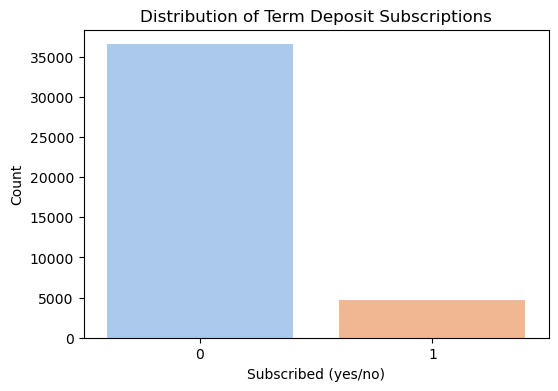

In [90]:
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=df, hue='y', palette='pastel', legend=False)
plt.title('Distribution of Term Deposit Subscriptions')
plt.xlabel('Subscribed (yes/no)')
plt.ylabel('Count')
plt.show()

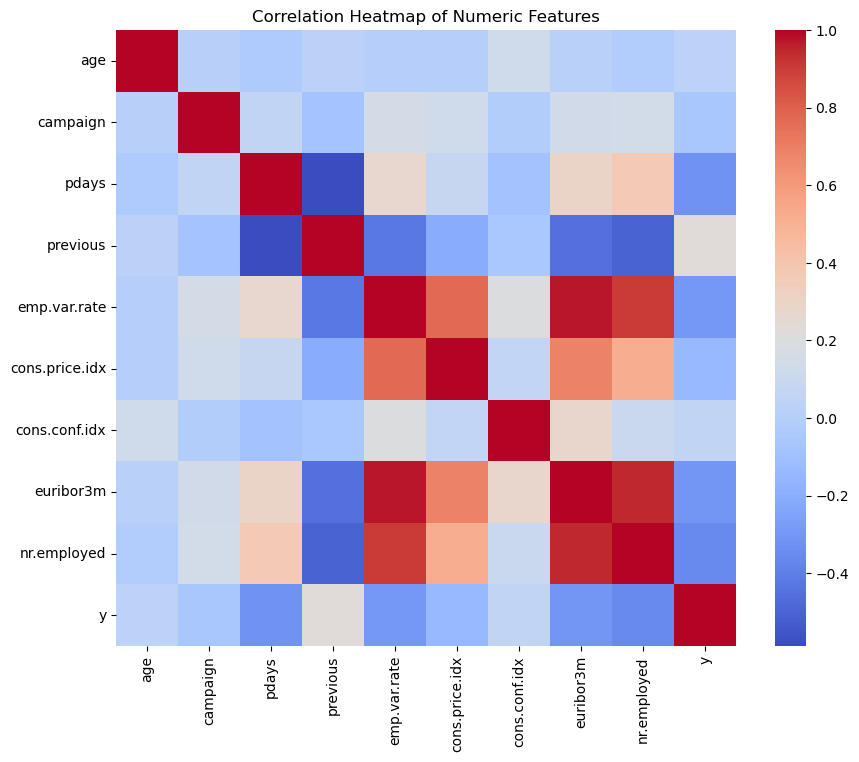

In [83]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes('number').corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


##### Questions